In [1]:
from pathlib import Path

INPUT_PATH = Path('../inputs')
OUTPUT_PATH = Path('../outputs')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from collections import OrderedDict
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore") 

torch.manual_seed(999)

class Net(nn.Module):
    def __init__(self, input_size, out_size):
        super(Net, self).__init__()
        layer1 = self.get_linear_with_relu(input_size, 500)
        layer2 = nn.Linear(500, out_size)
        self.layers = nn.ModuleList([layer1, layer2])
        self.forward_vals = []
        
    def forward(self, x):
        self.forward_vals.clear()
        for layer in self.layers:
            x = layer(x)
            self.forward_vals.append(x)
        return x
    
    def get_linear_with_relu(self, inp, out):
        return nn.Sequential(nn.Linear(inp, out), nn.ReLU())
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
train_kwargs = {'batch_size': batch_size,
               'shuffle': True}
test_kwargs = {'batch_size': batch_size,
              'shuffle': True}

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

dataset1 = datasets.MNIST(INPUT_PATH/'mnist', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST(INPUT_PATH/'mnist', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net(28*28, 10).to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1e-2)
            
model

Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): ReLU()
    )
    (1): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [3]:
len(train_loader)*batch_size

60032

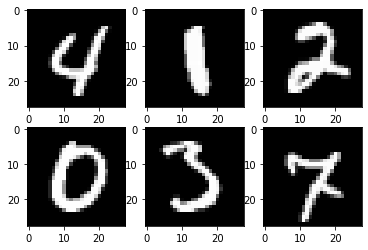

In [4]:
from matplotlib import pyplot as plt

examples = iter(test_loader)
example_data, example_targets = examples.next()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

### Target Model Training

In [5]:
# import copy
# import warnings
# warnings.filterwarnings("ignore") 

# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         # print(data.size(), data.view(data.size(0), -1).size())
#         optimizer.zero_grad()
#         output = model(data.view(data.size(0), -1))
#         loss = F.cross_entropy(output, target)
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 100 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
            

# def test():
#     with torch.no_grad():
#         n_correct = 0
#         n_samples = 0
#         for images, labels in test_loader:
#             images = images.reshape(-1, 28*28).to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             # max returns (value ,index)
#             _, predicted = torch.max(outputs.data, 1)
#             n_samples += labels.size(0)
#             n_correct += (predicted == labels).sum().item()

#     acc = 100.0 * n_correct / n_samples
#     print(f'Accuracy of the network on the 10000 test images: {acc} %')
#     return acc


# best_acc = -1
# best_model = None
# for epoch in range(1, 120):
#     train(model, device, train_loader, optimizer, epoch)
#     acc = test()
#     if acc > best_acc:
#         best_acc = acc
#         best_model = copy.deepcopy(model)
#         print(f'new best acc={best_acc}')
#     else:
#         print(f'current acc={acc}, prev_best_acc={best_acc}')

# state = {
#     'model_state': best_model.state_dict(),
#     'test_acc': best_acc
# }
# torch.save(state, OUTPUT_PATH/'state_small_nn.pt')
# print('best model saved')

### Reverse Model Training

In [6]:
state = torch.load(OUTPUT_PATH/'state_small_nn.pt')
state.keys()

dict_keys(['model_state', 'test_acc'])

In [7]:
model.load_state_dict(state['model_state'])
model.to(device)

for param in model.parameters():
    param.requires_grad = False
                                 
model

Net(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=500, bias=True)
      (1): ReLU()
    )
    (1): Linear(in_features=500, out_features=10, bias=True)
  )
)

In [36]:
config_dict = {
    'epochs': 700,
    'alpha': 1,
    'lr': 1e-2
}

In [37]:
class InvNet(nn.Module):
    def __init__(self, input_size, out_size):
        super(InvNet, self).__init__()
        layer1 = self.get_linear_with_relu(input_size, 500)
        layer2 = nn.Linear(500, out_size)
        self.layers = nn.ModuleList([layer1, layer2])
        self.forward_vals = []
        
    def forward(self, x):
        self.forward_vals.clear()
        for layer in self.layers:
            x = layer(x)
            self.forward_vals.append(x)
        return x
    
    def get_linear_with_relu(self, inp, out):
        return nn.Sequential(nn.Linear(inp, out), nn.ReLU())
    
inv_model = InvNet(10, 28*28)
inv_model.to(device)
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

test_kwargs = {'batch_size': batch_size,
              'shuffle': True}
test_qmnist = datasets.QMNIST(INPUT_PATH/'qmnist', train = False, download= True,
                             transform=transform)
print(f'size of inv data={test_qmnist}')
inv_data_loader = torch.utils.data.DataLoader(test_qmnist, **test_kwargs)

optimizer = optim.Adam(inv_model.parameters(), lr=config_dict['lr'])

inv_model

size of inv data=Dataset QMNIST
    Number of datapoints: 60000
    Root location: ../inputs/qmnist
    Split: test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


InvNet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=10, out_features=500, bias=True)
      (1): ReLU()
    )
    (1): Linear(in_features=500, out_features=784, bias=True)
  )
)

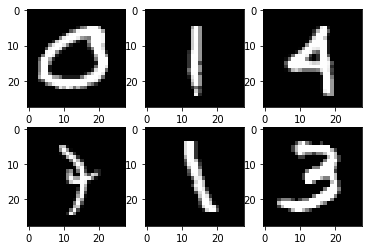

In [38]:
from matplotlib import pyplot as plt
import random

for i in range(6):
    example_data, example_target = test_qmnist[random.randint(0, len(test_qmnist))]
    plt.subplot(2,3,i+1)
    plt.imshow(example_data.squeeze(), cmap='gray')
plt.show()

In [39]:
import copy

tgt_to_inv_layer_map = {0: 1, 1: 0}

def train_inv(model, inv_model, device, data_loader, optimizer, epoch, alpha):
    model.train()
    
    total_loss = 0
    total_loss_layer = 0
    total_loss_img = 0
    total_loss_cyc = 0
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data, target = data.to(device).view(data.size(0), -1), target.to(device)  # torch.Size([128, 784]) torch.Size([128])
        optimizer.zero_grad()
    
        out = model(data)  
        inv_out = inv_model(out)
        
        # step 1- layer wise load
        loss_layer = layer_wise_loss(model, inv_model, data)
        
        # step 2- upto layer-k loss
        loss_img = F.l1_loss(inv_out, data)
        
        # step 3- full network output loss
        loss_cyc = cycle_consistency_inversion_loss(model, data, inv_out)
        
        loss = loss_layer + loss_img + (alpha*loss_cyc)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_loss_layer += loss_layer.item()
        total_loss_img += loss_img.item()
        total_loss_cyc += loss_cyc.item()
        
    return total_loss / (batch_idx+1), total_loss_layer / (batch_idx+1), \
            total_loss_img / (batch_idx+1), total_loss_cyc / (batch_idx+1)
        
        

def layer_wise_loss(model, inv_model, inp):
    loss = 0
    for layer_num, layer in enumerate(model.layers):
        tgt_layer_in = inp if layer_num == 0 else model.forward_vals[layer_num-1]  # get the input tensor for this layer in tgt model
        tgt_layer_out = model.forward_vals[layer_num]  # get the output of i-th target model layer 
        inv_layer = inv_model.layers[tgt_to_inv_layer_map[layer_num]]  # get the corresponding layer in reverse model
        inv_layer_out = inv_layer(tgt_layer_out)  # feed the target model layer output to reverse model layer
        loss += F.l1_loss(inv_layer_out, tgt_layer_in)  # outputs of both layer should be similar
        
    return loss


def cycle_consistency_inversion_loss(model, inp, inv_out):
    org_activations = copy.deepcopy(model.forward_vals)
    out_for_inv_input = model(inv_out)  # pass the input image generated by inverted network
    loss = 0
    for org_actv, actv in zip(org_activations, model.forward_vals):
        loss += F.l1_loss(actv, org_actv)
        
    return loss

In [43]:
import time
import sys
import wandb
import os
import numpy as np


def round_(n, d=5):
    return np.round(n, d)

run_id = 'lr_1e-2'
change_desc = 'larger LR 1e-2'
is_resume = True
run_path = OUTPUT_PATH/'runs'/run_id
run_path.mkdir(parents=True, exist_ok=True)

EPOCHS = config_dict['epochs']
ALPHA = config_dict['alpha']
start_epoch = 0
prev_best_loss = 999999
total_training_time = 0

state_path = run_path/'final_state_small_inv_nn.pt'

if is_resume and state_path.exists():
    state = torch.load(state_path)
    inv_model.load_state_dict(state['model_state'])
    optimizer.load_state_dict(state['optimizer'])
    start_epoch = state['epoch']+1
    prev_best_loss = state['prev_best_loss']
    print(f'resuming training for {run_id} from epoch {start_epoch}, last loss {state["loss"]} prev_best_loss {prev_best_loss}')
    

wandb.init(project='nn-are-reversible',
           entity='nayash', save_code=True, id=run_id,
           name=run_id, notes=change_desc,
           dir=run_path,
           resume='allow',
           config=config_dict)
wandb.watch(inv_model)

for epoch in range(start_epoch, EPOCHS):
    stime = time.time()
    total_loss, total_loss_layer, total_loss_img, total_loss_cyc = \
        train_inv(model, inv_model, device, inv_data_loader, optimizer, epoch, ALPHA)

    epoch_time = time.time() - stime
    total_training_time += epoch_time

    print(f'epoch={epoch}/{EPOCHS} loss={round_(total_loss)}, loss_layer={round_(total_loss_layer)}, loss_img={round_(total_loss_img)}, loss_cyc={round_(total_loss_cyc)}, epoch_duration={round(epoch_time)} secs')
    
    wandb.log({
        'loss':total_loss,
        'loss_layer':total_loss_layer,
        'loss_img':total_loss_img,
        'loss_cyc':total_loss_cyc
    })

    if total_loss < prev_best_loss:
        prev_best_loss = total_loss
        state = {
            'model_state': inv_model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': epoch,
            'loss': prev_best_loss
        }
        torch.save(state, run_path/'state_small_inv_nn.pt')
        print(f'new best loss={total_loss}')

        
state = {
    'model_state': inv_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': epoch,
    'loss': total_loss,
    'prev_best_loss': prev_best_loss
    }
torch.save(state, state_path)
        
print(f'{EPOCHS} finished in {total_training_time/60} mins')
wandb.finish()

wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


epoch=0/700 loss=1.51335, loss_layer=0.75188, loss_img=0.30314, loss_cyc=0.45832, epoch_duration=8 secs
new best loss=1.5133456345051846
epoch=1/700 loss=1.51316, loss_layer=0.75172, loss_img=0.30314, loss_cyc=0.4583, epoch_duration=8 secs
new best loss=1.513158120834497
epoch=2/700 loss=1.5148, loss_layer=0.75191, loss_img=0.30313, loss_cyc=0.45976, epoch_duration=8 secs
epoch=3/700 loss=1.51178, loss_layer=0.75148, loss_img=0.303, loss_cyc=0.45729, epoch_duration=8 secs
new best loss=1.5117752668954163
epoch=4/700 loss=1.51345, loss_layer=0.75166, loss_img=0.30312, loss_cyc=0.45867, epoch_duration=8 secs
epoch=5/700 loss=1.51106, loss_layer=0.75147, loss_img=0.3031, loss_cyc=0.45649, epoch_duration=9 secs
new best loss=1.5110565251124692
epoch=6/700 loss=1.51513, loss_layer=0.75168, loss_img=0.3032, loss_cyc=0.46024, epoch_duration=8 secs
epoch=7/700 loss=1.51222, loss_layer=0.75148, loss_img=0.30305, loss_cyc=0.4577, epoch_duration=8 secs
epoch=8/700 loss=1.51305, loss_layer=0.75151

KeyboardInterrupt: 

In [47]:
state = {
    'model_state': inv_model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': epoch,
    'loss': total_loss
    }
torch.save(state, state_path)
wandb.finish()

loss,1.50799
loss_layer,0.74682
loss_img,0.30228
loss_cyc,0.45889
_runtime,1951
_timestamp,1635018222
_step,226


loss,▆▅▄█▆▅▆▅▇▄▆▅▅▅▆▄▅▅▅▅▅▅▃▂▄▃▃▂▃▄▂▄▁▂▃▃▁▁▃▃
loss_layer,██▇▇▇▇▇▆▆▆▆▅▅▅▅▄▅▄▅▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
loss_img,██▇▇▇▇▆▆▇▆▆▆▅▆▆▅▅▅▅▅▅▄▄▃▄▃▃▃▃▃▃▃▂▂▂▂▁▁▂▁
loss_cyc,▅▃▂█▄▄▅▄█▃▅▅▅▅▆▃▄▅▆▅▅▅▄▂▅▂▄▂▄▅▃▅▁▁▄▄▂▁▄▅
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


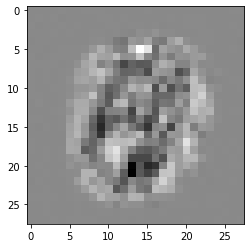

In [48]:
state = torch.load(run_path/'final_state_small_inv_nn.pt')
inv_model.load_state_dict(state['model_state'])

inp = torch.tensor([0.9, 0, 0, 0, 0, 0, 0, 0, 0., 0.]).to(device)
o = inv_model(inp)
img = o.reshape((28, 28)).cpu().detach().numpy()
plt.imshow(img, cmap='gray')
plt.show()